## Notebook to load catalog data, and perform the iteration

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import astropy.units as u
import gc
from astropy.coordinates import SkyCoord, GeocentricTrueEcliptic
from library.snr import optimal_snr
from library.lisa_psd import noise_psd_AE

/home/alice/miniforge3/envs/gwpy_env/lib/python3.12/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal
PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


## Step 1: pre-process the catalog

In the terminal, run:

`python preprocess_catalog.py     --filepath filepath  
   --output output_filenam.h5     --T_obs T_obs      --delta_t deltat      --tdi 1.5 or 2.0     --snr_preselection snr_preselection      --batch_size bach_size `

/home/alice/catalog_binaries/catalogue_interaction_WDWD_processed.hdf5

default parameters: T_obs = 126144000 (4 years), delta_t = 5, tdi = 1.5, snr_preselection = 0.01, batch_size = 1000


## Step 2: load processed data 

In [2]:
from library.iteration_utils import load_waveforms, setup, run_iterative_separation

data = load_waveforms('processed_all_snr001_2yrs.h5')

## Step 3: prepare state and parameters for the iteration and run it

Set SNR threshold and name of the output file with the resolved sources data. In `run_iterative_separation`, you can set the maximum number of iterations and the size of the median filter for the smoothing of the PSD, as well as turn on/off plots and saving the results.

Starting with 15539324 total sources
15273965 sources already pre-excluded and added to the confusion
265359 candidate sources to run the iteration
Frequency range: 1.97e-04 to 2.04e-02 Hz
SNR threshold: 7

--- Step 0: Instrument-only SNR pre-exclusion
  Unresolvable sources (added to confusion): 40952
  SNR candidates for iteration: 224407

--- Iteration 1 ---
Size of the binning for the median filter: 3.170979198359805e-05


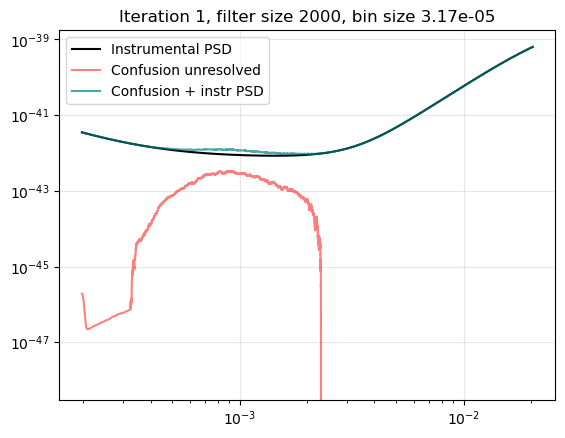

  New resolved: 0
  Still unresolved: 224407
  Total resolved: 0

Converged after 1 iterations!

FINAL RESULTS:
  Total sources: 15539324
  Resolved: 0 (0.0%)
  Unresolved: 15539324 (100.0%)

Saving resolved sources to results_all_snr7_2yrs_sel001...
Saved 0 resolved sources to results_all_snr7_2yrs_sel001


In [3]:
snr_thr = 7
results_filename = 'results_all_snr7_2yrs_sel001'
T_obs = data['T_obs']
max_iterations = 50
filter_size = 2000

state = setup(data, snr_calculator= lambda source: optimal_snr(source["A"], source["psd_total"], T_obs=T_obs), 
              psd_instrumental=noise_psd_AE, 
              snr_threshold=snr_thr,
              filter_size=filter_size)
del data
gc.collect()
results = run_iterative_separation(state,  
                                   max_iterations=max_iterations, 
                                   filter_size=filter_size, 
                                   print_progress=True, 
                                   plot= True, 
                                   save_results=True, 
                                   output_file= results_filename)

Text(0, 0.5, 'PSD A')

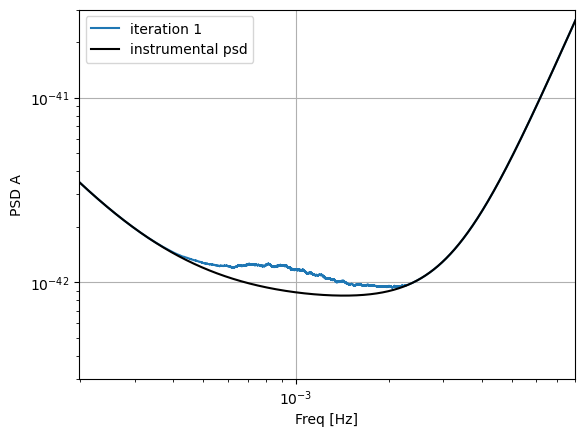

In [4]:
freqs = results['global_fr']
fig, ax = plt.subplots(1, 1)
for i, psd in results['psd_confusion']:
    ax.loglog(freqs, psd, label=f"iteration {i}")
ax.loglog(freqs, noise_psd_AE(freqs, tdi = 1.5), color='black', label = 'instrumental psd')
ax.set_xlim(freqs[0], 8e-3)
ax.set_ylim(3e-43, 3e-41)
ax.grid()
ax.legend()
ax.set_xlabel("Freq [Hz]")
ax.set_ylabel("PSD A")